In [1]:
# sefa manipulation from projected W+ latent

In [2]:
import copy
import os
import os.path as osp
import re
from tqdm import tqdm
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F

import legacy
from face_alignment import image_align
from landmarks_detector import LandmarksDetector
from sefa import factorize_weight
from projector import project

In [3]:
# set device
device = torch.device('cuda:3')
# set model paths
ckptbasedir = '/workspace/stylegan3encoder/ckpts/'
network_pkl = osp.join(ckptbasedir, 'stylegan3-t-ffhq-1024x1024.pkl')
landmark_ckpt_path = osp.join(ckptbasedir, 'dlib', 'shape_predictor_68_face_landmarks.dat')
VGG16url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'

In [4]:
# load models
landmark_detector = LandmarksDetector(landmark_ckpt_path)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)
with dnnlib.util.open_url(VGG16url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)

In [5]:
# set optimizer hparam
num_steps = 200
initial_lr = 0.05
lr_rampdown_length = 0.25
lr_rampup_length = 0.25
w_avg_samples = 10000
seed = 1

optimizer_kwargs = dict(
    num_steps=num_steps,
    initial_lr=initial_lr,
    lr_rampdown_length=lr_rampdown_length,
    lr_rampup_length=lr_rampup_length,
    w_avg_samples=w_avg_samples,
    seed=seed
)

In [6]:
target_path = '/workspace/stylegan3encoder/data/test/24.png'

In [7]:
# set paths
src = target_path
fn = osp.basename(src).split('.')[0]
# load & face align images
aligned = '/workspace/stylegan3encoder/jupyter/cache/aligned_{}.png'.format(fn)
print("src", src)
print("aligned", aligned)
try:
    face_landmark = list(landmark_detector.get_landmarks(src))[0]
    assert isinstance(face_landmark, list)
    assert len(face_landmark) == 68
    image_align(src, aligned, face_landmark)
except:
    im = Image.open(src)
    im.save(aligned) 

src /workspace/stylegan3encoder/data/test/24.png
aligned /workspace/stylegan3encoder/jupyter/cache/aligned_24.png


In [8]:
latent = project(G, vgg16, device, aligned, **optimizer_kwargs)
codes = latent

Setting up PyTorch plugin "bias_act_plugin"... Done.
torch.Size([1, 16, 512]) cuda:3
torch.Size([1, 1, 512])


  0%|                                                             | 0/200 [00:00<?, ?it/s]

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


100%|███████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.71it/s]


In [9]:
# factorize weight
distances = np.linspace(-30,30,7)
layers, boundaries, values = factorize_weight(G)

In [10]:
semantic_ind = 1 # 0 ~ 511
boundary = boundaries[semantic_ind:semantic_ind+1]

In [11]:
imgs = []
for dist in distances:
    temp_code = copy.deepcopy(codes)
    temp_code[:,[1,2],:] += boundary * dist
    img = G.synthesis(torch.from_numpy(temp_code).to(device), noise_mode='const', force_fp32=True)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')) #.save(f'{outdir}/{fn}.png')

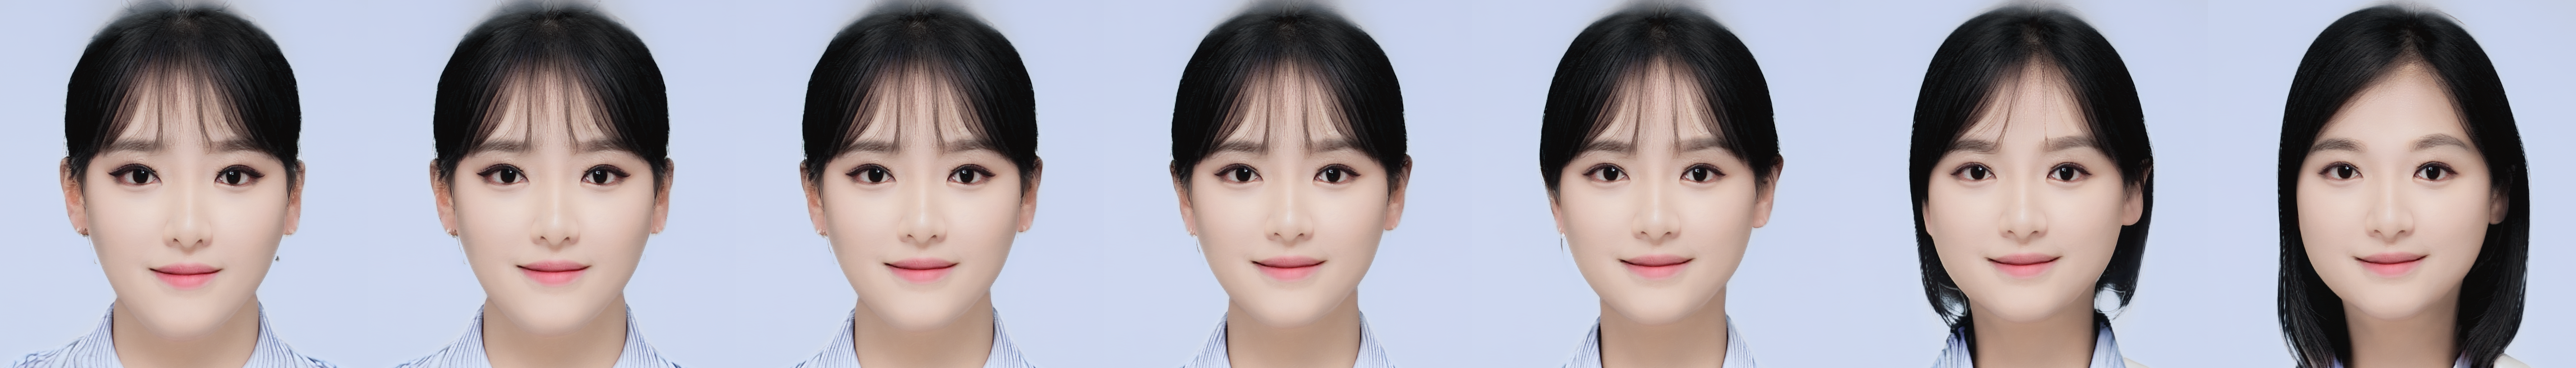

In [12]:
gw, gh = (7, 1)
H, W = (1024,1024)
result = np.stack(imgs)
result = result.reshape(gh, gw, H, W, 3)
result = result.transpose(0,2,1,3,4)
result = result.reshape(gh * H, gw * W, 3)
display(PIL.Image.fromarray(result, 'RGB'))